# Becca's 1st time series notebook
### Mix of Leo and Mampi's notebooks

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
# GridSpec letws us align plots carefully
from matplotlib import gridspec

import scipy.stats as stats
import netCDF4
import numpy as np
import pandas as pd
from netCDF4 import Dataset
from scipy import signal

In [2]:
f = netCDF4.Dataset(r'C:\Users\rhamm\Dropbox\RSMAS\AppliedDataAnalysis\TCHP.nc')
print(f) 

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: spatial statistic of TCHP
    description: AOML TC Heat Potential -80--20E 30-0N
    minimal_valid_fraction:  30.00
    file: AOMLData/heat.nc
    node_offset:                0
    nco_openmp_thread_number:                1
    institution: KNMI Climate Explorer
    ave_region: lon=  -80.100  -19.900, lat=   -0.100   30.100
    comment: operating on TCHP, <a href=http://climexp.knmi.nl/select.cgi?field=ts_heat>climexp.knmi.nl/select.cgi?field=ts_heat</a>, averaging anomalies over region lon=  -80.100  -19.900, lat=   -0.100   30.100, via the KNMI Climate Explorer (http://climexp.knmi.nl)
    history:  2018-04-02 16:52:18 bin/dat2nc data/its_heat_-80--20E_30-0N_n.dat i AOML_TC_Heat_Potential_-80--20E_30-0N data/its_heat_-80--20E_30-0N_n.nc\n 2018-03-28 19:08:19 bin/get_index AOMLData/heat.nc -80 -20 30 0 dipole no minfac 30 nearest ts_heat_-80--20E_30-0N_n\nMon Apr 28 11:45:47 2008: 

In [3]:
print(f.variables.keys()) # get all variable names 

odict_keys(['time', 'heat'])


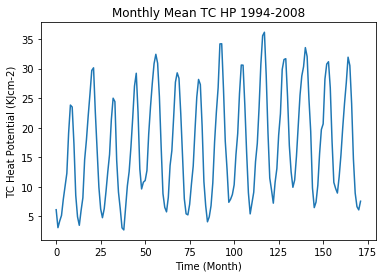

In [4]:
f.variables
T  = np.array(f.variables['time'])  #time
HP = np.array(f.variables['heat'])  #heat potential
HP[HP==3e+33]=np.nan                #Remove nans
T  = T[~np.isnan(HP)]
HP = HP[~np.isnan(HP)]
#HP.shape
#print(HP)
plt.plot(T,HP)
plt.xlabel('Time (Month)');plt.ylabel('TC Heat Potential (KJcm-2)');
plt.title('Monthly Mean TC HP 1994-2008');

In [5]:
def fig1():
    fig=plt.figure()
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 
    ax=fig.add_subplot(gs[0])
    ax.plot(T,HP)
    ax.set_xlabel('Time [months]');ax.set_ylabel('TC Heat Potential (KJcm-2)');
    ax=fig.add_subplot(gs[1]); ax.set_xlabel('PDF & normal approx.')
    n,bins,pa=ax.hist(HP,101,orientation='horizontal', \
                      normed='True',label='pdf of V')
    # Approximate it with a normal distribution of same mean and std
    normapprox = stats.norm.pdf(bins,loc=np.mean(HP),scale=np.std(HP)) 
    ax.plot(normapprox, bins)

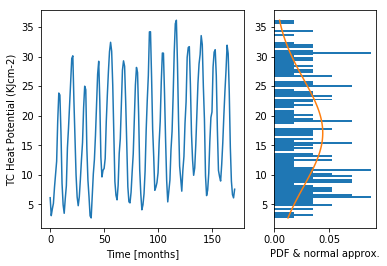

In [6]:
fig1()

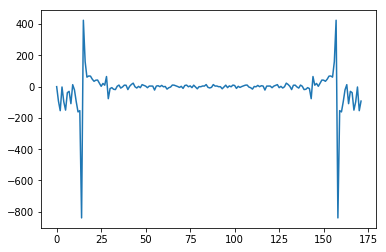

In [7]:
# Take the simple FFT, after removing the mean

HPp = HP - HP.mean()

#To match the sign above, roll the array so it starts at t=0. 
# Vp = np.roll(Vp, int(-NT/2) ) Too fussy: just know the sign is opposite

# BOOM! Notice there is no time axis, just the values, hence the roll issue above
HPspec = np.fft.fft( HPp )

# It is symmetric, with low frequencies at BOTH ENDS, except 0 (the mean)
fig,ax=plt.subplots(1,1) 
ax.plot(HPspec.real)

In [12]:

# Define the frequencies "freqs" (noting the symmetry -- but 0 occurs only at left)

freqs = np.array(range(len(T)))   # This gets the left end correct
reversed_freqs = freqs[::-1]  # Reverse the array 
reversed_freqs[0:int(NT/2)] = freqs[1:int(NT/2)+1] # Fix the low end of the reversed array
freqs = reversed_freqs[::-1]  # reverse it back 

fig,ax=plt.subplots(1,1) 
ax.stem(freqs, HPspec.real)
ax.set_xlim([0,N + 5])
ax.set_xlabel('Cycles per (length of record)')
ax.set_ylabel('Some measure of cosine component amplitude')

ValueError: could not broadcast input array from shape (171) into shape (172)

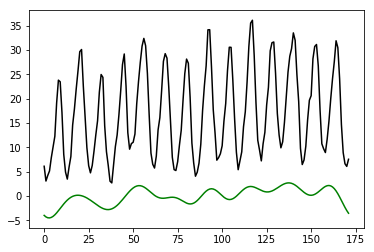

In [19]:
# Mess with the spectrum and reconstruct (a way of filtering)

# Truncate the frequencies higher then TRUNC cycles per record length
TRUNC = 10

HPspec_trunc = HPspec.copy()
HPspec_trunc[np.where(freqs > TRUNC)] *= 0. 
HPrecon = np.fft.ifft(HPspec_trunc).real

# How's the reconstruction? 
fig,ax=plt.subplots(1,1) 
ax.plot(HP,      color='black')
ax.plot(HPrecon,  color='green')